# Práctica 2. Filtrado espacial de imágenes biomédicas
## Apertura y pasos previos

In [1]:
import numpy as np
import pydicom as pdc
import matplotlib.pyplot as plt
import cv2
# %matplotlib inline

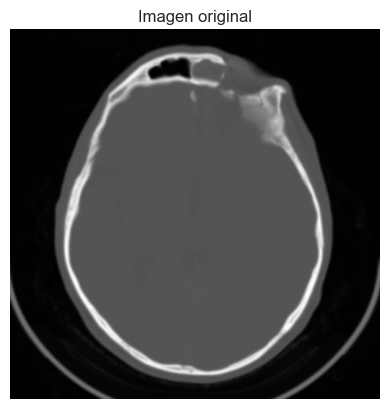

In [96]:
# Abrir la imagen
def abrir_imagen(num_imagen):
    return pdc.dcmread(fr"C:\Users\Gonzalo_MA\Desktop\Universidad\Tercero\Imagenes biomedicas\Practica 1/im{num_imagen}.dcm")

imagen = abrir_imagen(8)

# Guardar la imagen en una matriz de datos indicando los bits por pixel
def imagen_bits(imagen, bpp = 12):
    if bpp == 12:
        sol = np.array(imagen.pixel_array)
    elif bpp == 8:
        sol = (np.array(imagen.pixel_array) * (255/4095)).astype(np.uint8)
    return sol, bpp

# Creaamos la matriz de la imagen con 12 bpp
imagen_pixeles, bpp = imagen_bits(imagen, 12)

# Visualizamos la imagen
plt.imshow(imagen_pixeles, cmap = 'gray') # cmap = "gray", camp = "jet", cmap = "viridis"
plt.axis('off')
plt.title("Imagen original")
plt.show()

## Ejercicio 1
### Filtro paso bajo
#### Funciones

In [80]:
def filtro_pb(imagen, tam_kernel = 5):
    # Creamos el kernel
    kernel = np.ones((tam_kernel, tam_kernel))

    # Pad de la imagen e inicialización
    t = tam_kernel//2
    im_pad = np.pad(imagen, t)
    im_filtrada = np.zeros((512, 512))

    # Aplicamos la convolucion
    for x in range(t, 512+t):
        for y in range(t, 512+t):
            im_filtrada[x-t, y-t] = (np.sum(kernel * im_pad[x-t:x+t+1, y-t:y+t+1]))/(tam_kernel**2)

    return im_filtrada.astype(np.uint16)

def ventana(imagen, vmin, vmax):
    # Valores por debajo del min puestos a 0
    # Valores por encima del max puestos puestos al valor max del tipo de datos
    clipeada = np.clip(imagen, a_min=vmin, a_max=vmax)
    # Reescalamiento para que la ventana ocupe todos los valores de píxeles
    clipeada = ((clipeada - vmin)/(vmax - vmin))*((2**bpp)-1)
    return clipeada

def histograma_2(imagen):
    # Calculamos las veces que aparece cada valor
    valores, cuenta = np.unique(imagen.flatten(), return_counts= True)
    # Pasamos a frecuencias relativas
    cuenta = cuenta/(512*512)
    return valores, cuenta

# Dibuja una linea vertical 
def linea(arg):
    plt.vlines(x = arg, ymin = 0, ymax = 0.005, colors = "orange")

#### Histograma

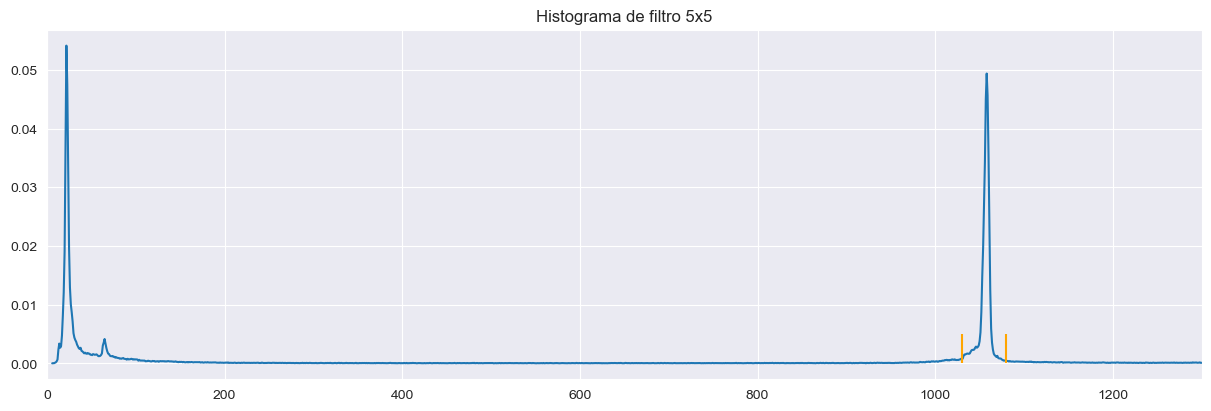

In [4]:
filtrada_5x5 = filtro_pb(imagen_pixeles, 5)
valores, cuenta = histograma_2(filtrada_5x5)

_, ax = plt.subplots(figsize = (12, 4), layout = "constrained")
ax.plot(valores, cuenta)
ax.set(xlim=(0, 1300))
ax.set_title("Histograma de filtro 5x5")
linea(1030)
linea(1080)

#### Visualización

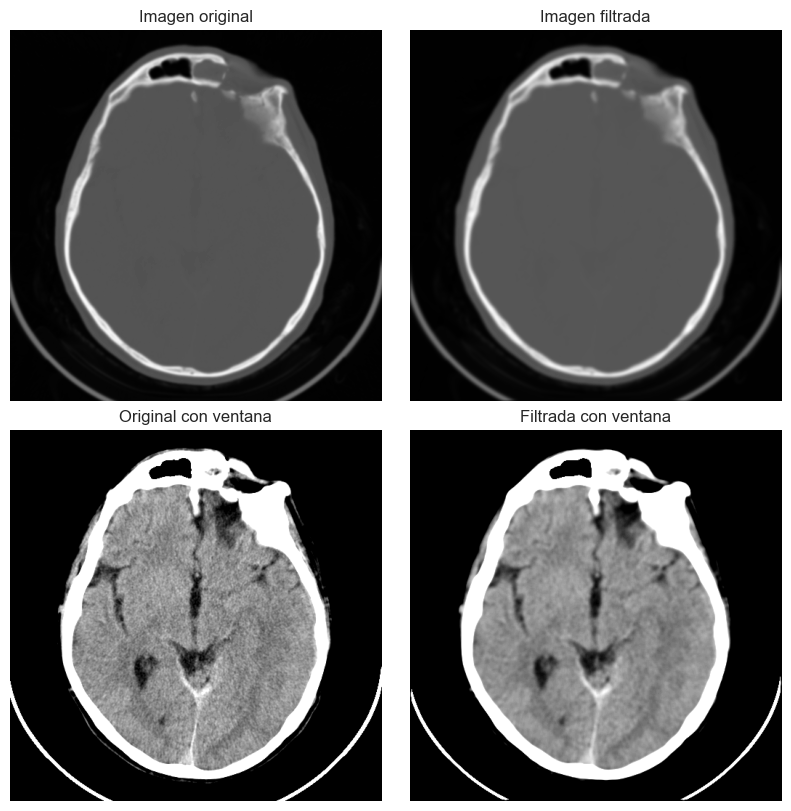

In [5]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_pixeles, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(filtrada_5x5, cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Imagen filtrada")
ax[1,1].imshow(ventana(filtrada_5x5, 1030, 1080),cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Filtrada con ventana")
ax[1,0].imshow(ventana(imagen_pixeles, 1030, 1080), cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Original con ventana")
plt.grid(False)
plt.axis(False)
plt.show()

### Filtro de Sobel
#### Funciones

In [6]:
def sobel(imagen):
    # Pad de la imagen e inicialización
    im_pad = np.pad(imagen, 1)
    sobel_x = np.zeros((512, 512))
    sobel_y = np.empty((512, 512))
    
    # Creamos los kernels
    gx = np.array([[-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]])
    gy = gx.T
    
    # Aplicamos las convoluciones
    for x in range(1, 513):
        for y in range(1, 513):
            sobel_y[x-1, y-1] = np.sum(gx * im_pad[x-1:x+2, y-1:y+2])

    for x in range(1, 513):
        for y in range(1, 513):
            sobel_x[x-1, y-1] = np.sum(gy * im_pad[x-1:x+2, y-1:y+2])
    
    # Modulo y fase
    sobel_xy = np.sqrt(sobel_x**2 + sobel_y**2)
    fase = np.arctan2(sobel_y, sobel_x)
    
    return sobel_x, sobel_y, sobel_xy.astype(np.uint16), fase

#### Visualización sin filtrado paso bajo

In [7]:
s_x, s_y, s_xy, _ = sobel(imagen_pixeles)

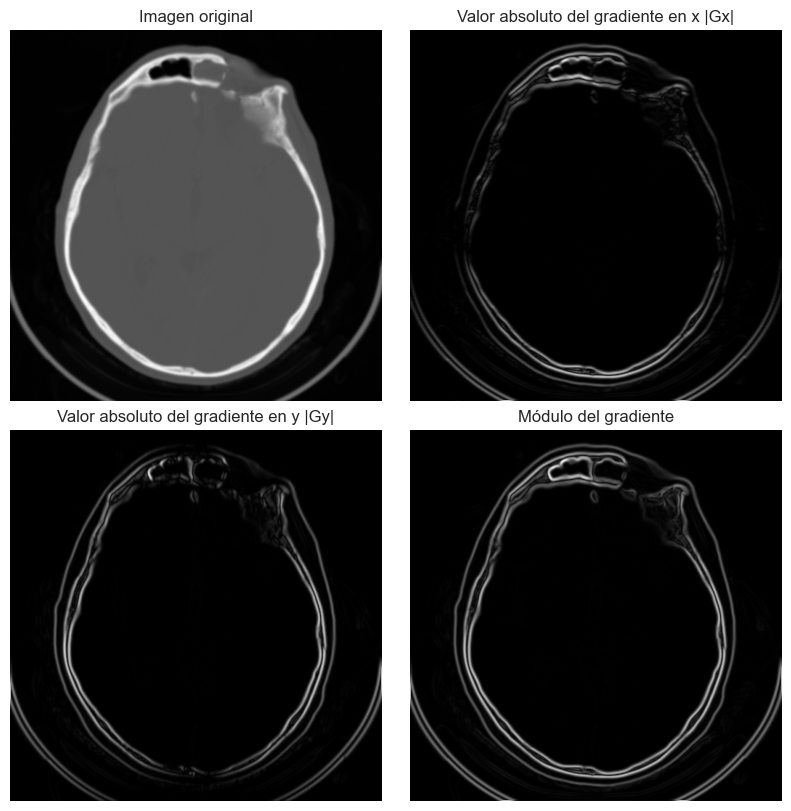

In [8]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_pixeles, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(np.abs(s_x), cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Valor absoluto del gradiente en x |Gx|")
ax[1,0].imshow(np.abs(s_y), cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Valor absoluto del gradiente en y |Gy|")
ax[1,1].imshow(s_xy, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Módulo del gradiente")

plt.grid(False)
plt.axis(False)
plt.show()

#### Visualización con filtrado paso bajo

In [9]:
s_xf, s_yf, s_xyf, _ = sobel(filtro_pb(imagen_pixeles, 5))

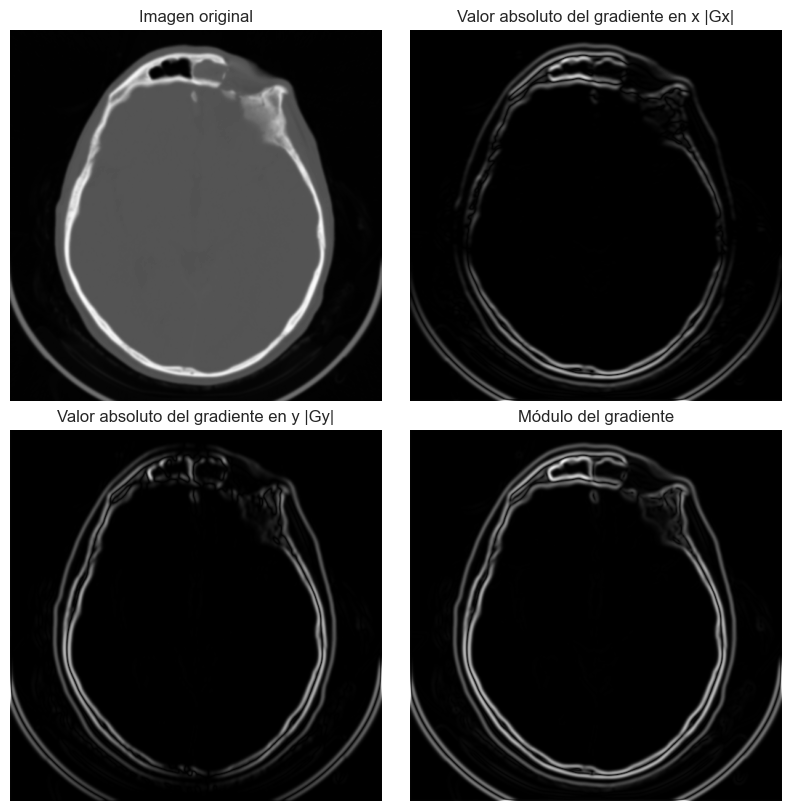

In [10]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_pixeles, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(np.abs(s_xf), cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Valor absoluto del gradiente en x |Gx|")
ax[1,0].imshow(np.abs(s_yf), cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Valor absoluto del gradiente en y |Gy|")
ax[1,1].imshow(s_xyf, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Módulo del gradiente")

plt.grid(False)
plt.axis(False)
plt.show()

#### Viusalización con ventana

In [11]:
v = ventana(imagen_pixeles, 1030, 1080)
s_xv, s_yv, s_xyv, _ = sobel(v)

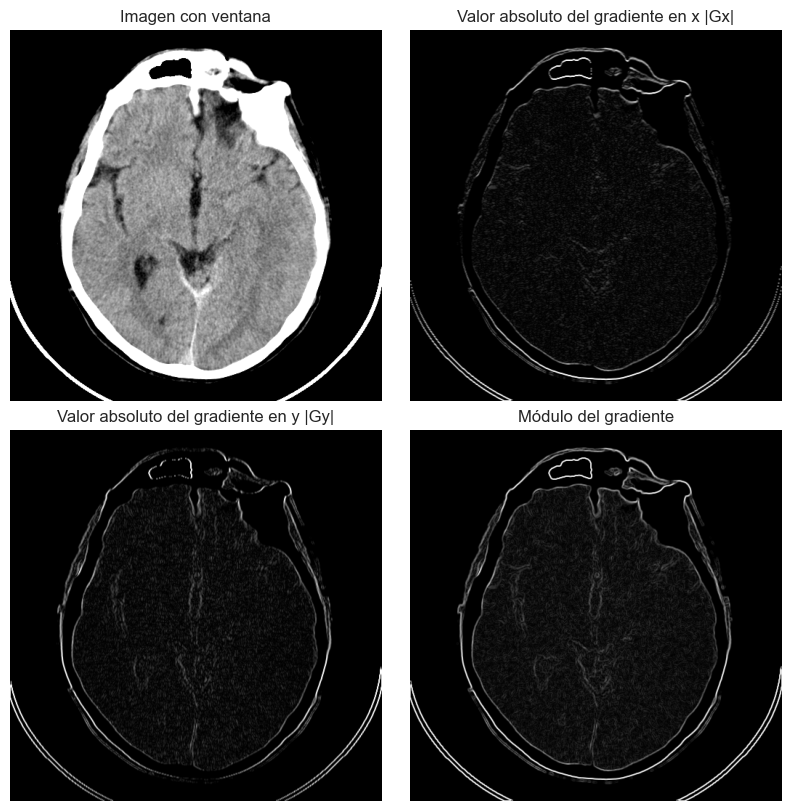

In [12]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(v, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen con ventana")
ax[0,1].imshow(np.abs(s_xv), cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Valor absoluto del gradiente en x |Gx|")
ax[1,0].imshow(np.abs(s_yv), cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Valor absoluto del gradiente en y |Gy|")
ax[1,1].imshow(s_xyv, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Módulo del gradiente")

plt.grid(False)
plt.axis(False)
plt.show()

#### Visualización con ventana y filtro

In [13]:
vf = filtro_pb(ventana(imagen_pixeles, 1030, 1080), 5)
s_xvf, s_yvf, s_xyvf, _ = sobel(vf)

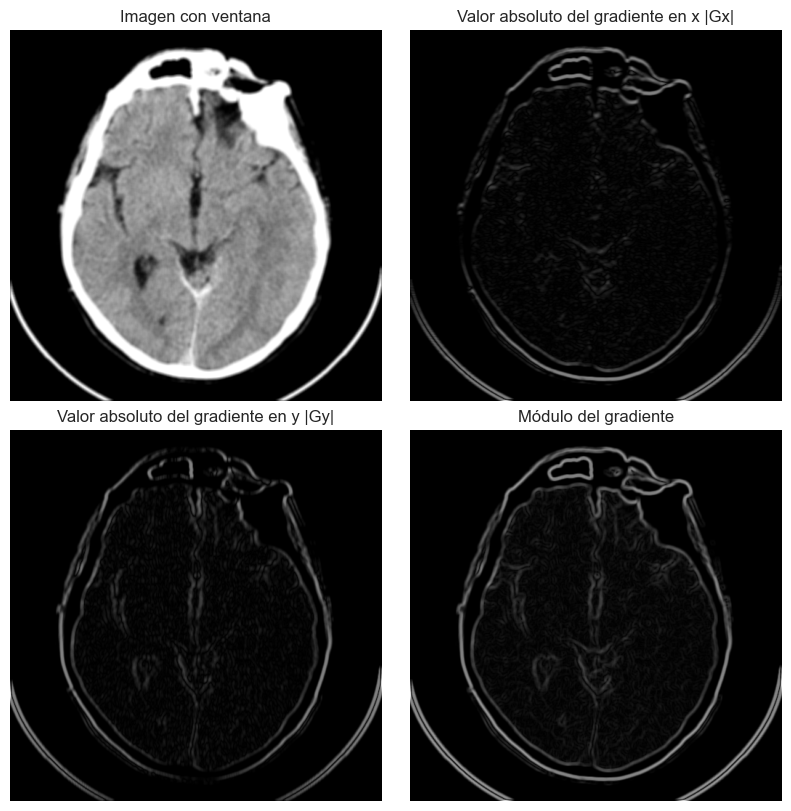

In [85]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(vf, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen con ventana")
ax[0,1].imshow(np.abs(s_xvf), cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Valor absoluto del gradiente en x |Gx|")
ax[1,0].imshow(np.abs(s_yvf), cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Valor absoluto del gradiente en y |Gy|")
ax[1,1].imshow(s_xyvf, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Módulo del gradiente")

plt.grid(False)
plt.axis(False)
plt.show()

#### Comparación

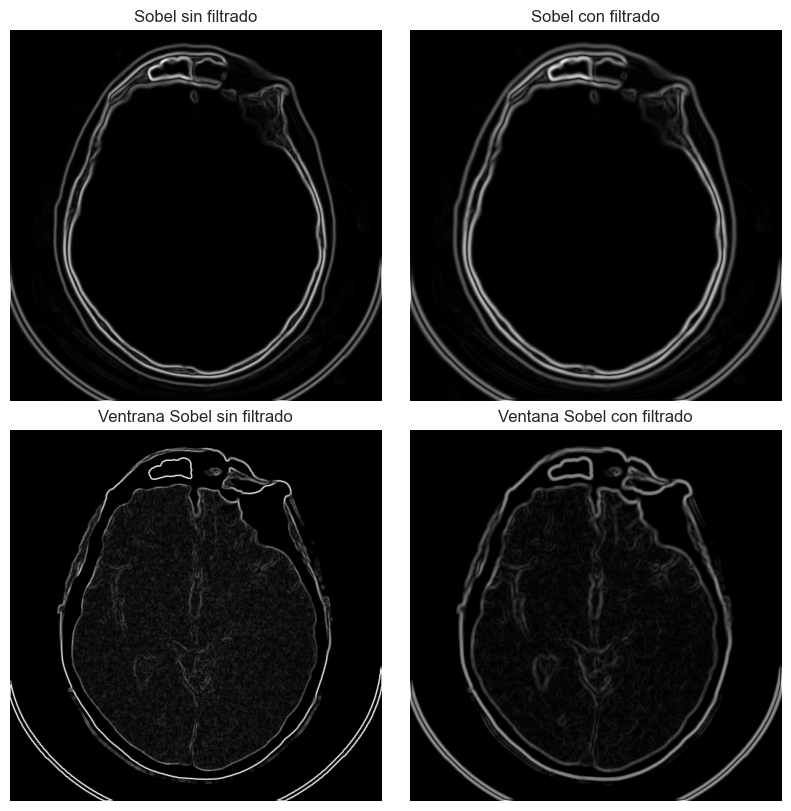

In [15]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(s_xy, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Sobel sin filtrado")
ax[0,1].imshow(s_xyf, cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Sobel con filtrado")
ax[1,0].imshow(s_xyv, cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Ventrana Sobel sin filtrado")
ax[1,1].imshow(s_xyvf, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Ventana Sobel con filtrado")
plt.show()

### Filtro de Prewitt
#### Funciones

In [16]:
def prewitt(imagen):
    # Pad de la imagen e inicialización
    im_pad = np.pad(imagen, 1)
    prewitt_x = np.zeros((512, 512))
    prewitt_y = np.empty((512, 512))

    # Creamos los kernels
    gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    gy = gx.T

    # Aplicamos las convoluciones
    for x in range(1, 513):
        for y in range(1, 513):
            prewitt_y[x-1, y-1] = np.sum(gx * im_pad[x-1:x+2, y-1:y+2])

    for x in range(1, 513):
        for y in range(1, 513):
            prewitt_x[x-1, y-1] = np.sum(gy * im_pad[x-1:x+2, y-1:y+2])

    # Modulo y fase
    prewitt_xy = np.sqrt(prewitt_x**2 + prewitt_y**2)
    fase = np.arctan2(prewitt_y, prewitt_x)

    return prewitt_x, prewitt_y, prewitt_xy.astype(np.uint16), fase

#### Visualización sin filtrado paso bajo

In [17]:
p_x, p_y, p_xy, _ = prewitt(imagen_pixeles)

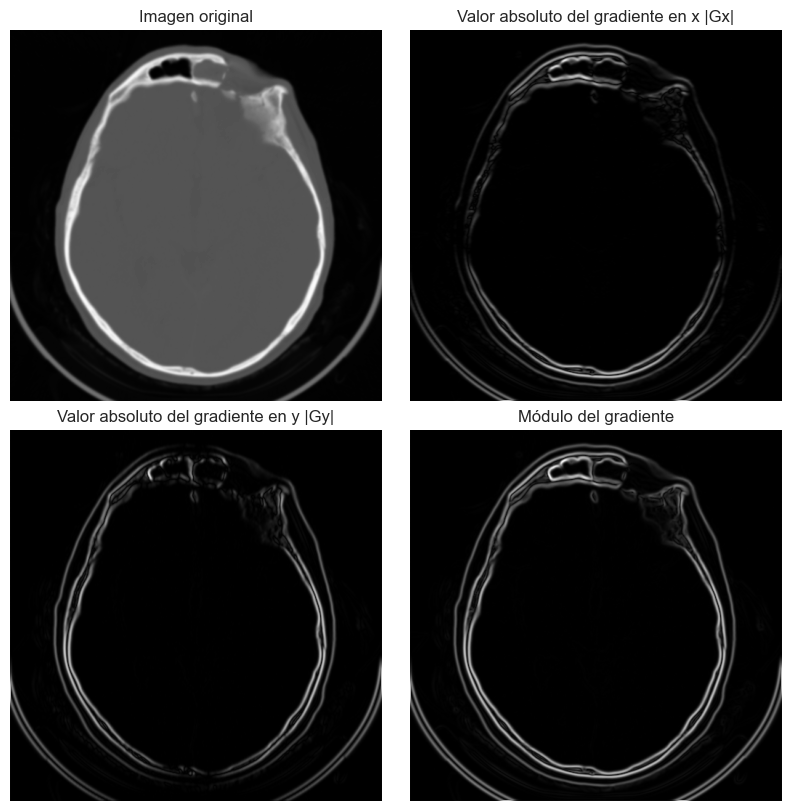

In [18]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_pixeles, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(np.abs(p_x), cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Valor absoluto del gradiente en x |Gx|")
ax[1,0].imshow(np.abs(p_y), cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Valor absoluto del gradiente en y |Gy|")
ax[1,1].imshow(p_xy, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Módulo del gradiente")

plt.grid(False)
plt.axis(False)
plt.show()

#### Visualización con ventana

In [19]:
p_xv, p_yv, p_xyv, _ = prewitt(v)

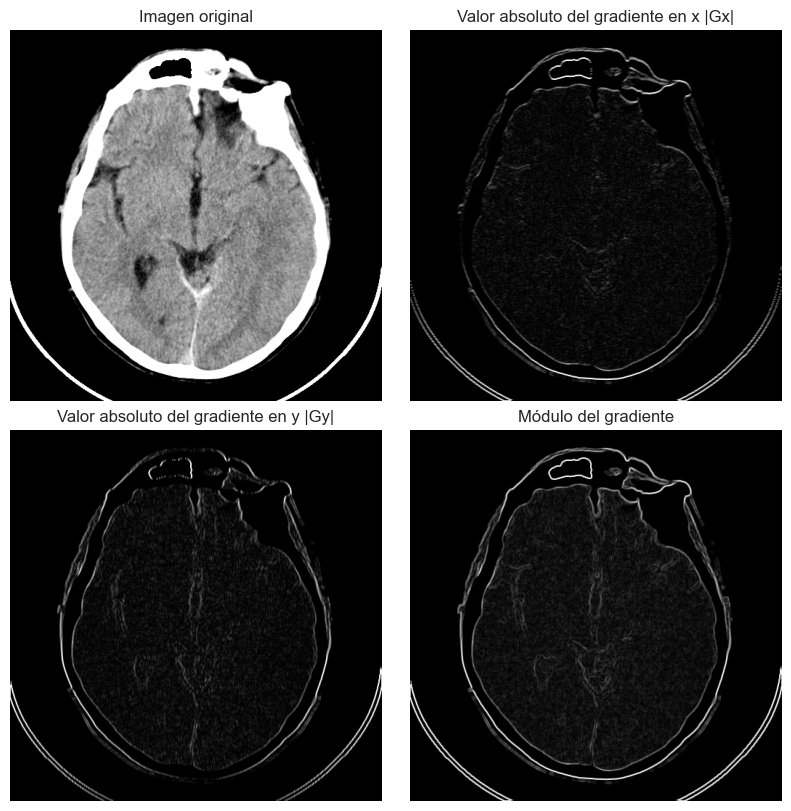

In [20]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(v, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(np.abs(p_xv), cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Valor absoluto del gradiente en x |Gx|")
ax[1,0].imshow(np.abs(p_yv), cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Valor absoluto del gradiente en y |Gy|")
ax[1,1].imshow(p_xyv, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Módulo del gradiente")

plt.grid(False)
plt.axis(False)
plt.show()

#### Comparación

In [21]:
p_xvf, p_yvf, p_xyvf, _ = prewitt(vf)
p_xf, p_yf, p_xyf, _ = prewitt(filtro_pb(imagen_pixeles,5))

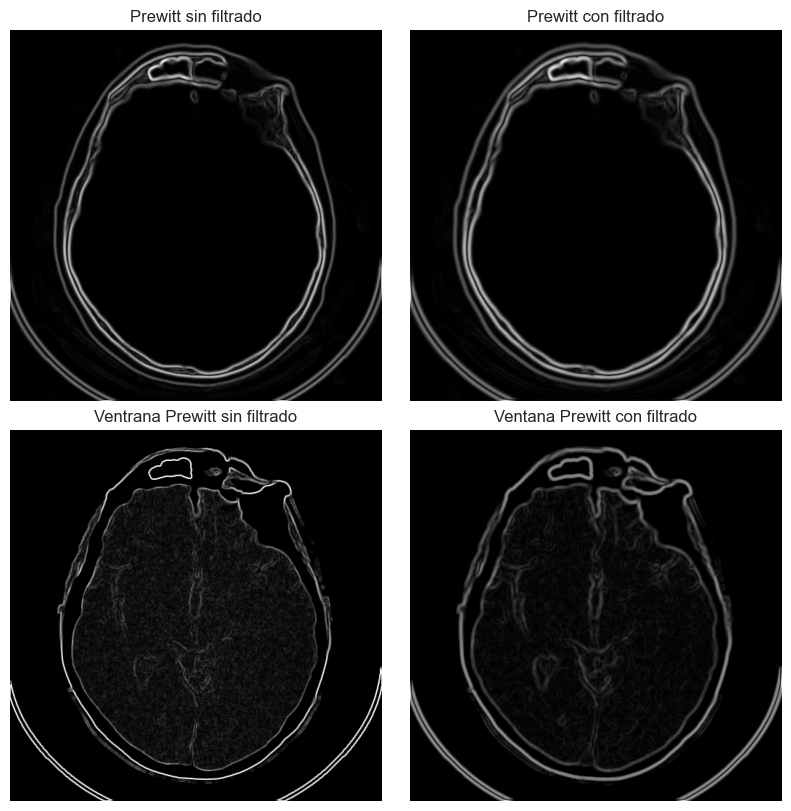

In [22]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(p_xy, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Prewitt sin filtrado")
ax[0,1].imshow(p_xyf, cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Prewitt con filtrado")
ax[1,0].imshow(p_xyv, cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Ventrana Prewitt sin filtrado")
ax[1,1].imshow(p_xyvf, cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Ventana Prewitt con filtrado")
plt.show()

### Filtro gaussiano
#### Funciones

In [23]:
def gauss(imagen, tamano = 5, desviacion = 1):
    # Creamos el kernel
    t =  tamano//2
    kernel = np.fromfunction(lambda x, y: 
                             (1/ (2 * np.pi * desviacion ** 2)) * np.exp(-((x - t) ** 2 + (y - t) ** 2) / (2 * desviacion ** 2)),
                             (tamano, tamano))
    suma_kernel = np.sum(kernel)
    
    # Pad de la imagen e inicialización  
    im_pad = np.pad(imagen, t)
    im_filtrada = np.zeros((512, 512))

    # Aplicamos la convolucion
    for x in range(t, 512+t):
        for y in range(t, 512+t):
            im_filtrada[x-t, y-t] = (np.sum(kernel * im_pad[x-t:x+t+1, y-t:y+t+1]))/(suma_kernel)

    return im_filtrada.astype(np.uint16)

#### Visualización

In [24]:
filtrada_gauss = gauss(imagen_pixeles)

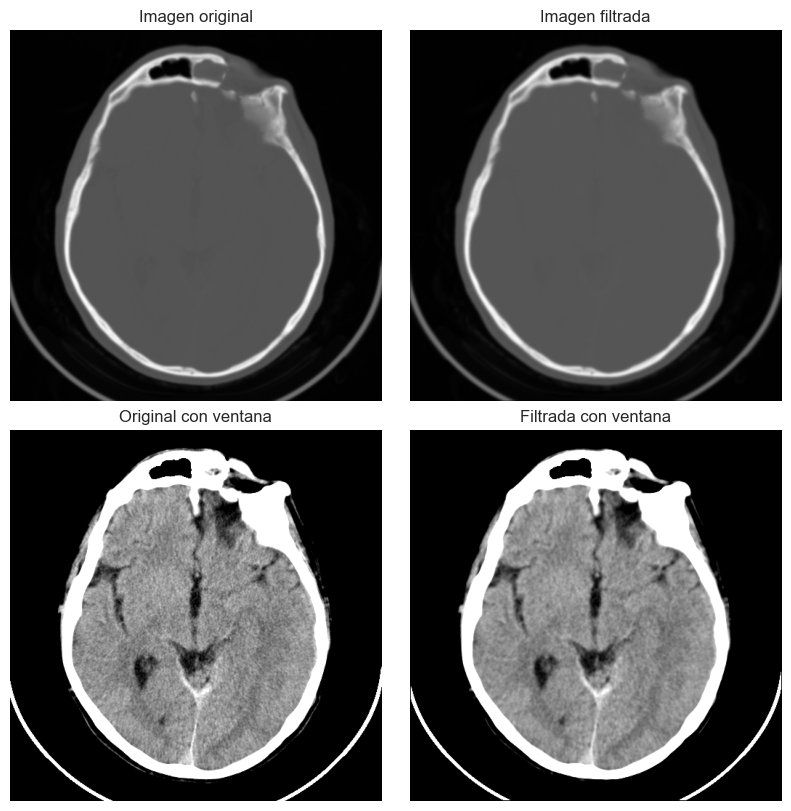

In [25]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_pixeles, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(filtrada_gauss, cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Imagen filtrada")
ax[1,1].imshow(ventana(filtrada_gauss, 1030, 1080),cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Filtrada con ventana")
ax[1,0].imshow(v, cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Original con ventana")
plt.grid(False)
plt.axis(False)
plt.show()

### Filtro laplaciano
#### Funciones

In [26]:
def laplaciano(imagen):
    # Creamos el kernel 
    kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
    
    # Pad de la imagen e inicialización  
    im_pad = np.pad(imagen, 1)
    im_filtrada = np.zeros((512, 512), dtype=np.int32)

    # Aplicamos la convolucion
    for x in range(1, 513):
        for y in range(1, 513):
            im_filtrada[x-1, y-1] = (np.sum(kernel * im_pad[x-1:x+2, y-1:y+2]))

    im_orig_y_filtr = imagen.astype(np.int32) + im_filtrada
    
    #im_filtrada = np.clip(im_filtrada, 0, (2**bpp)-1)
    im_orig_y_filtr = np.clip(im_orig_y_filtr, 0, (2**bpp)-1)
    
    return im_filtrada, im_orig_y_filtr.astype(np.uint16)

#### Visualización

In [27]:
filtrada_laplaciano, original_y_filtrada = laplaciano(imagen_pixeles)
filtrada_laplaciano_v, original_y_filtrada_v = laplaciano(v)

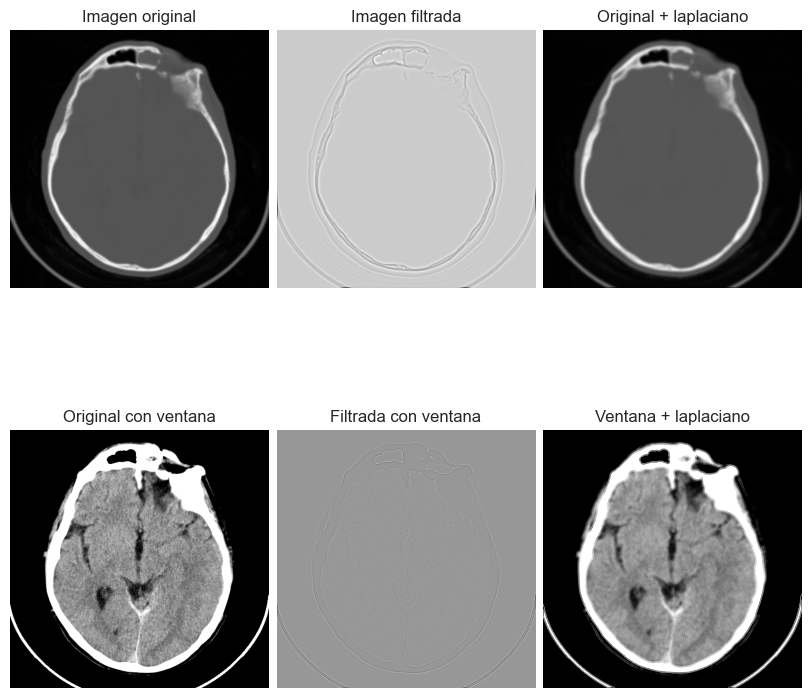

In [28]:
_, ax = plt.subplots(2, 3, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_pixeles, cmap = "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(filtrada_laplaciano, cmap = "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Imagen filtrada")
ax[1,1].imshow(filtrada_laplaciano_v,cmap = "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Filtrada con ventana")
ax[1,0].imshow(v, cmap = "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Original con ventana")  
ax[0,2].imshow(original_y_filtrada, cmap = "gray")
ax[0,2].axis("off")
ax[0,2].set_title("Original + laplaciano")
ax[1,2].imshow(original_y_filtrada_v, cmap = "gray")
ax[1,2].axis("off")
ax[1,2].set_title("Ventana + laplaciano")
plt.grid(False)
plt.axis(False)
plt.show()

### Filtro laplaciano de una gaussiana LoG
#### Funciones

In [29]:
'''
# factor = factor por el que se multiplica la imagen filtrada antes de sumarla a la original
def LoG(imagen, desviacion, tamano, factor):
    # Creamos el kernel 
    t = tamano//2
    kernel = np.fromfunction(lambda x, y:
                             (np.exp(-(((x-t)**2 + (y-t)**2)/(2*(desviacion**2)))))*
                             (((x-t)**2 + (y-t)**2 - 2*(desviacion**2))/(desviacion**4)),
                             (tamano, tamano))
    
    suma_kernel = np.sum(kernel)
    # Pad de la imagen e inicialización  
    im_pad = np.pad(imagen, t)
    im_filtrada = np.zeros((512, 512), dtype=np.float64)

    # Aplicamos la convolucion
    for x in range(t, 512+t):
        for y in range(t, 512+t):
            im_filtrada[x-t, y-t] = (np.sum(kernel * im_pad[x-t:x+t+1, y-t:y+t+1]))/(suma_kernel)

    im_filtrada = im_filtrada.round(0).astype(np.int64)
    
    im_orig_y_filtr = imagen + factor*im_filtrada

    #im_orig_y_filtr = np.clip(im_orig_y_filtr, 0, (2**bpp)-1)
    im_orig_y_filtr = ventana(im_orig_y_filtr, 0, np.max(im_orig_y_filtr))

    return im_filtrada, im_orig_y_filtr.astype(np.uint16)
'''

In [101]:
def LoG(imagen):
    # Aplica un filtro gaussiano
    imagen_suavizada = cv2.GaussianBlur(imagen, (5, 5), 1)

    # Aplica el operador Laplaciano
    filtro_log_cv2 = cv2.Laplacian(imagen_suavizada, cv2.CV_16U, ksize=5)

    return np.clip(v + 0.02*filtro_log_cv2, 0, 4095)

In [102]:
filtrada_LoG = LoG(imagen_pixeles)
filtrada_LoG_v = LoG(v)

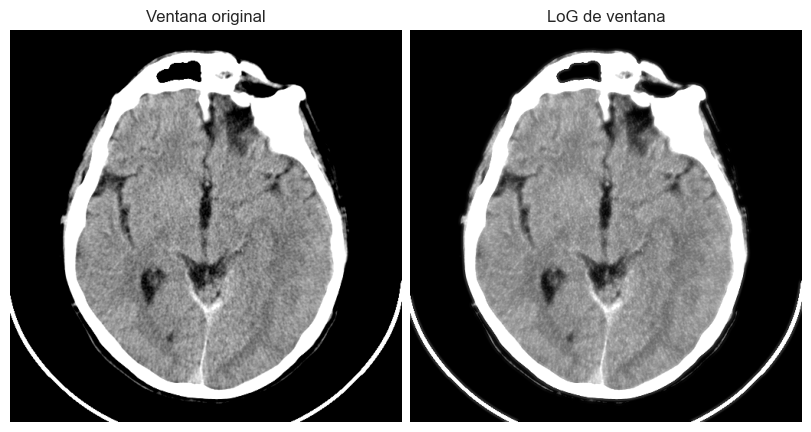

In [103]:
_, ax = plt.subplots(1, 2, figsize = (8, 16), layout = "constrained")

ax[1].imshow(filtrada_LoG_v, cmap = "gray")
ax[1].axis("off")
ax[1].set_title("LoG de ventana")
ax[0].imshow(v, cmap = "gray")
ax[0].axis("off")
ax[0].set_title("Ventana original")

plt.grid(False)
plt.axis(False)
plt.show()

## Ejercicio 2
### Sobel binarizado

[(-10.0, 3000.0), (0.0, 0.01)]

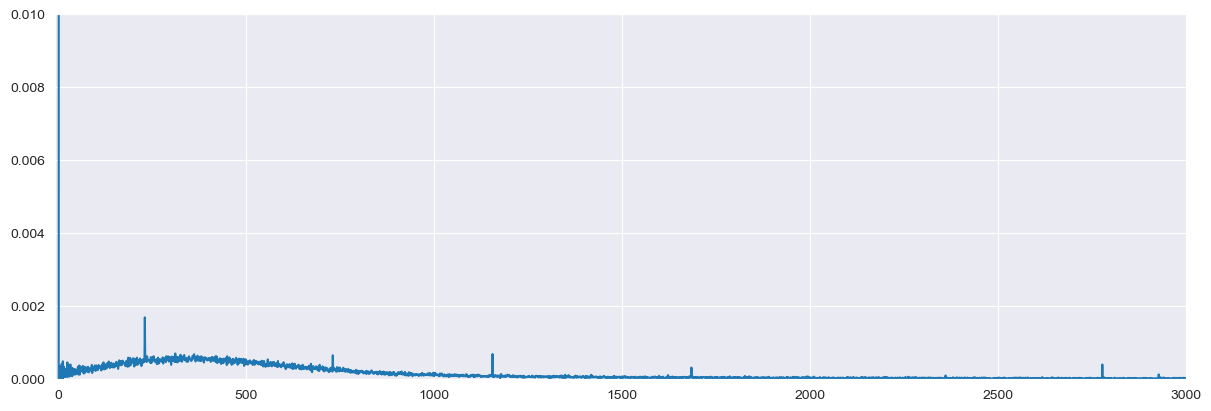

In [32]:
valores, cuenta = histograma_2(s_xyvf)

_, ax = plt.subplots(figsize = (12, 4), layout = "constrained")
ax.plot(valores, cuenta)
ax.set(xlim=(-10, 3000), ylim = (0, 0.01))

#### Sobre ventana

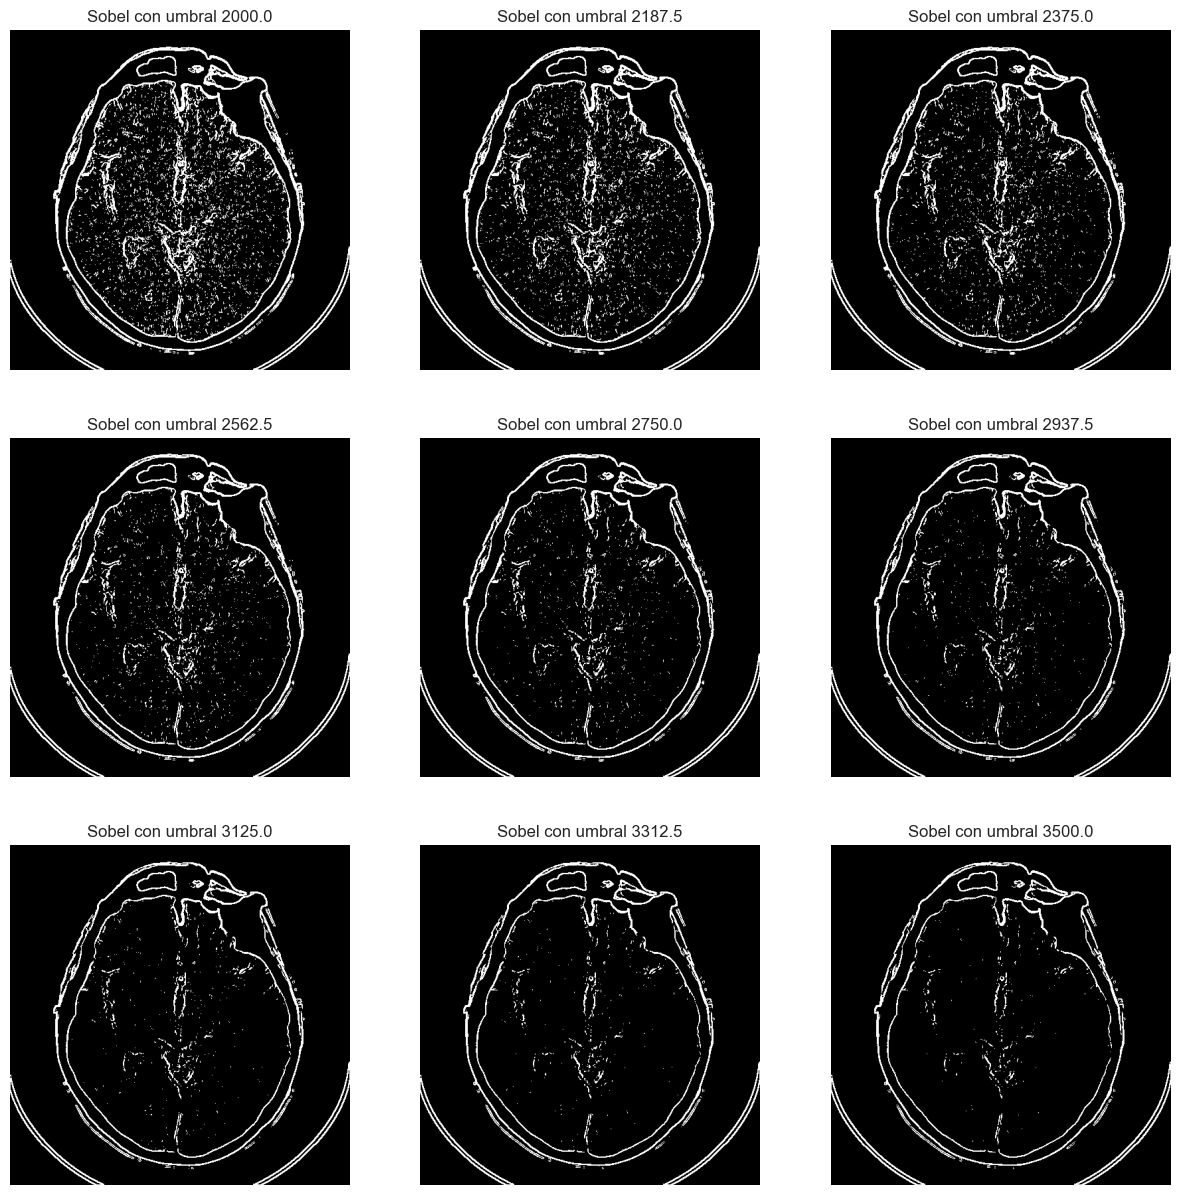

In [33]:
umbrales = np.linspace(2000, 3500, 9).tolist()
_, ax = plt.subplots(3, 3, figsize = (15, 15))

i = 0
for x in range(3):
    for y in range(3):
        umbral = umbrales[i]
        ax[x,y].imshow(1 - (s_xyv < umbral), cmap = "gray")
        ax[x,y].axis("off")
        ax[x,y].set_title(f"Sobel con umbral {umbral}")
        i += 1

#### Sobre ventana filtrada

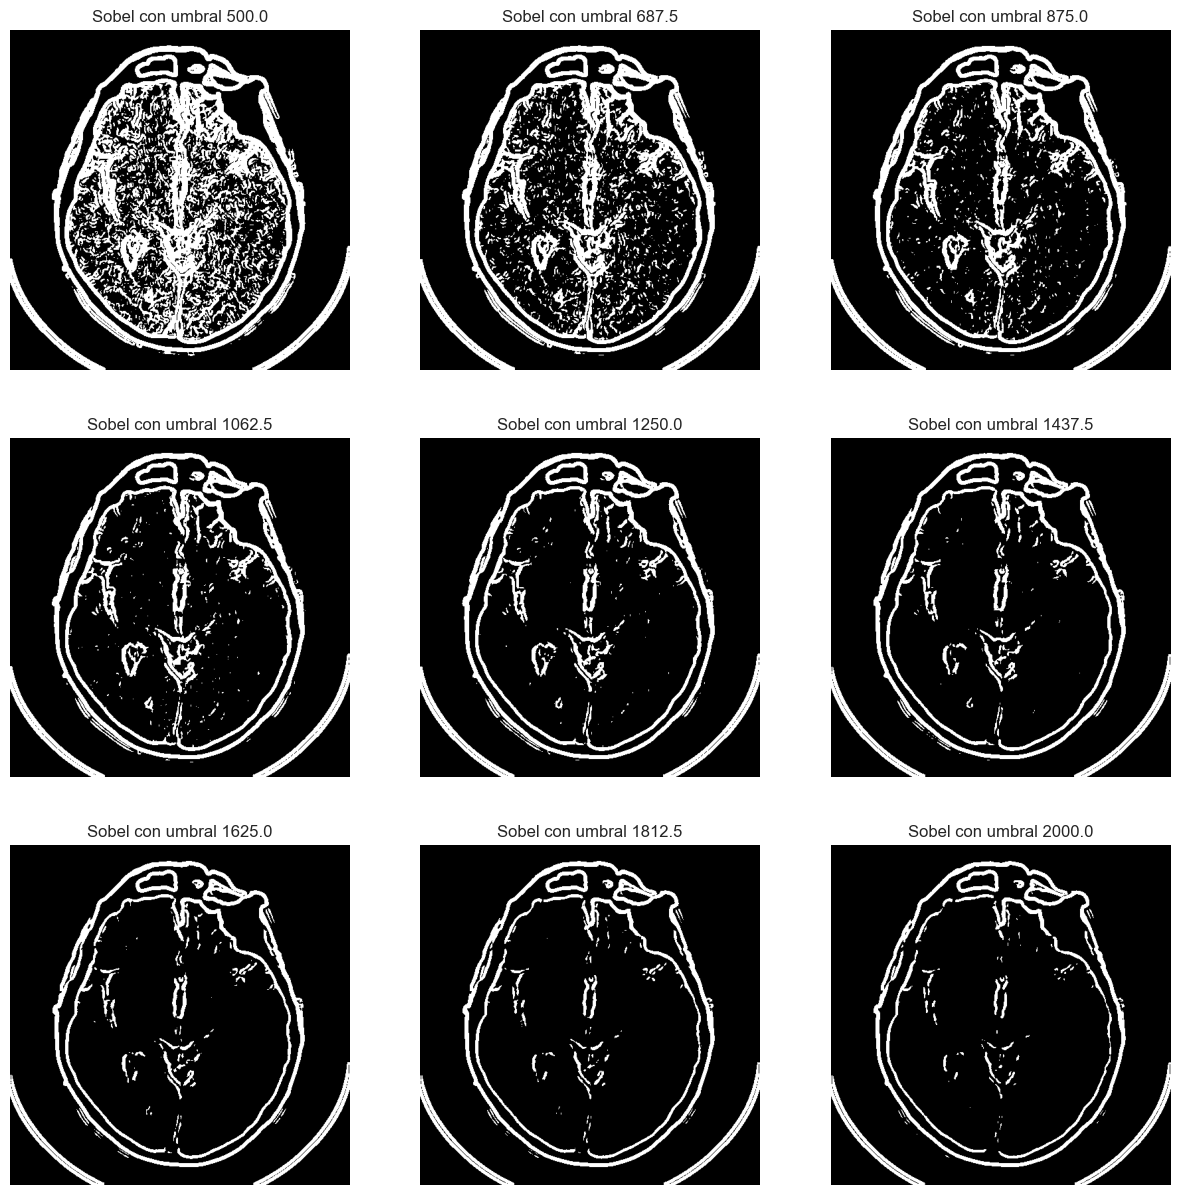

In [34]:
umbrales = np.linspace(500, 2000, 9).tolist()
_, ax = plt.subplots(3, 3, figsize = (15, 15))

i = 0
for x in range(3):
    for y in range(3):
        umbral = umbrales[i]
        ax[x,y].imshow(1 - (s_xyvf < umbral), cmap = "gray")
        ax[x,y].axis("off")
        ax[x,y].set_title(f"Sobel con umbral {umbral}")
        i += 1

#### Comparacion

Text(0.5, 1.0, 'Sobel binario sobre ventana filtrada')

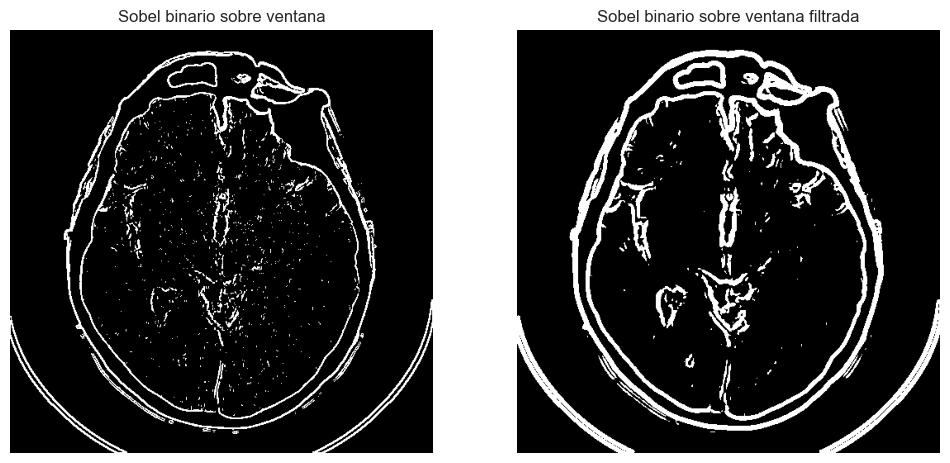

In [35]:
_, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].imshow(1- (s_xyv < 2750), cmap = "gray")
ax[0].axis("off")
ax[0].set_title("Sobel binario sobre ventana")
ax[1].imshow(1- (s_xyvf < 1250), cmap = "gray")
ax[1].axis("off")
ax[1].set_title("Sobel binario sobre ventana filtrada")

### Filtro de canny

In [36]:
imagen_8bpp, bpp = imagen_bits(imagen, 8)
#v_8bpp = ventana(imagen_8bpp, 60, 70)
v_8bpp = (v * (255/4095)).astype(np.uint8)

imagen_original_8bpp_suavizada = cv2.GaussianBlur(imagen_8bpp, (5, 5), 1.0)
ventana_8bpp_suavizada = cv2.GaussianBlur(v_8bpp, (5, 5), 1.0)

imagen_original_8bpp_suavizada = cv2.convertScaleAbs(imagen_original_8bpp_suavizada)
ventana_8bpp_suavizada = cv2.convertScaleAbs(ventana_8bpp_suavizada)

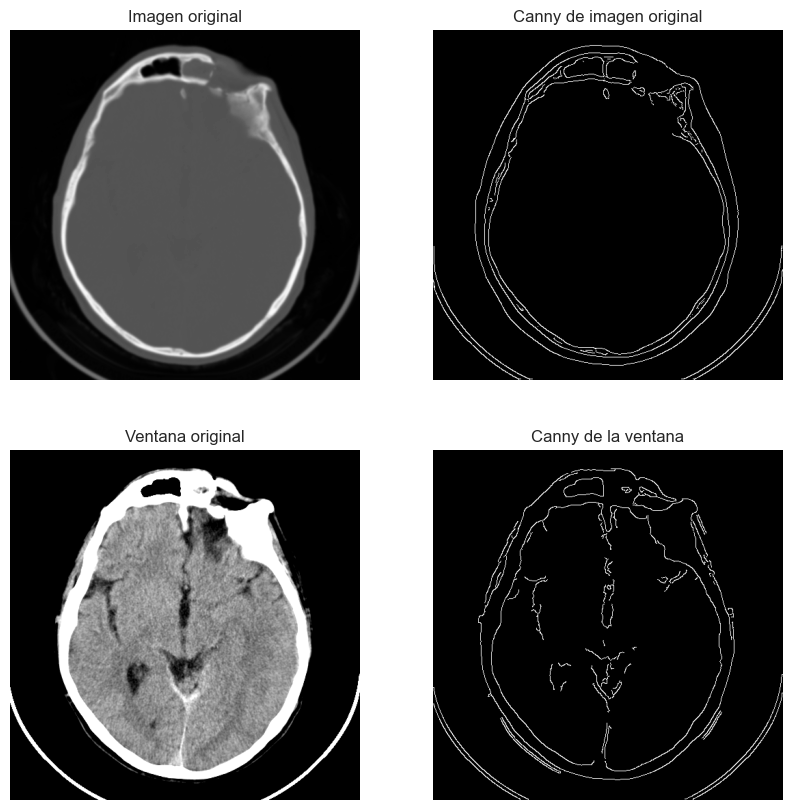

In [37]:
canny_original = cv2.Canny(imagen_original_8bpp_suavizada, 0, 40)
canny_ventana = cv2.Canny(ventana_8bpp_suavizada, 120, 250)

_, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0,0].imshow(imagen_8bpp, cmap= "gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(canny_original, cmap= "gray")
ax[0,1].axis("off")
ax[0,1].set_title("Canny de imagen original")
ax[1,0].imshow(v_8bpp, cmap= "gray")
ax[1,0].axis("off")
ax[1,0].set_title("Ventana original")
ax[1,1].imshow(canny_ventana, cmap= "gray")
ax[1,1].axis("off")
ax[1,1].set_title("Canny de la ventana")
plt.show()